In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import IPython.display as ipd
import iisignature as iisig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
import pyximport
pyximport.install()
%load_ext Cython
import sigkernel as ksig
from utils.data import *

# Data preprocessing

In [2]:
sample_len = 30

In [41]:
with open(f'./data/dataframes/theorytab/melodies_beats_min_5_unique_max_range_24.pkl', 'rb') as f:
    df_titles = pickle.load(f)
len(df_titles)

7271

### Transform to gap, duration, delta pitch format

In [42]:
gap_dur_dpitch_dfs = gap_duration_deltapitch_transform([item[0] for item in df_titles])
dataset = GapDurationDeltaPitchDataset(gap_dur_dpitch_dfs, sample_len=sample_len, stride=10000)
len(dataset) == len(df_titles)

True

### Transform to rectilinear path

In [6]:
X = []
for i in range(len(dataset)):
    data, cluster_id = dataset[i]
    X.append(data)
X = torch.stack(X)
X = batch_rectilinear_with_gap_transform(X)
Xs = X.numpy()
Xs.shape, X.shape

((7271, 60, 2), torch.Size([7271, 60, 2]))

### Calculate signature and cluster

In [7]:
signatures = []
for path in Xs:
    signatures.append(iisig.sig(path, 5))
signatures = np.array(signatures)
signatures.shape

(7271, 62)

(array([7.212e+03, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 5.700e+01]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

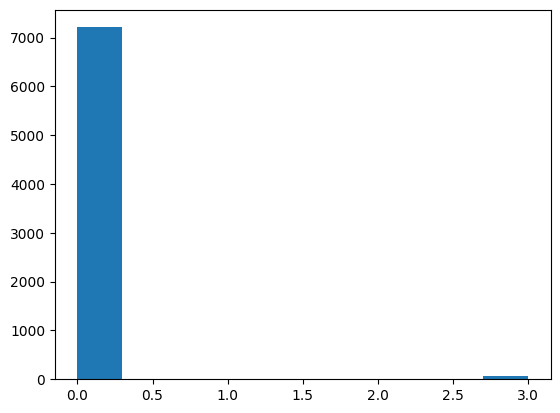

In [8]:
labels = cluster.KMeans(n_clusters=4).fit(signatures).labels_
plt.hist(labels)

### Compute Gram matrix of signature kernel with rational quadratic static kernel

In [9]:
static_kernel = ksig.static.kernels.RationalQuadraticKernel(sigma=1.0)
kernel = ksig.kernels.SignatureKernel(n_levels=5, order=1, normalization=0, static_kernel=static_kernel, device_ids=None)

In [ ]:
# calculate gram matrix in batches
batch_size = 15
gram_matrix = torch.empty(len(X), len(X))
for i in range(int(len(X) / batch_size)+1):
    print((i+1)*batch_size)
    gram_matrix[i*batch_size:(i+1)*batch_size] = kernel(X[i*batch_size:(i+1)*batch_size].to('cuda'), X.to('cuda')).cpu()
# torch.save(gram_matrix, f'./data/gram_matrices/gram_matrix_melodies_beats_min_5_unique_max_range_24.pt')

In [46]:
# gram_matrix = torch.load(f'./data/gram_matrices/gram_matrix_melodies_beats_min_5_unique_max_range_24.pt')
# gram_matrix = torch.tril(gram_matrix) + torch.tril(gram_matrix, diagonal=-1).T # make it symmetric as numerical errors make it not symmetric
# gram_matrix.shape

torch.Size([7271, 7271])

In [ ]:
# sns.heatmap(torch.tril(gram_matrix, diagonal=-1), cmap='viridis')

### Analyse gram matrix and cluster to eliminate outliers

In [12]:
# Test alignment of kernel matrix with list of dataframe indices
sample_idx = 158
print([item[1:] for item in df_titles[sample_idx:sample_idx+1]])
midi_data = df_to_midi(batch_gap_duration_pitch_to_df(dataset[sample_idx][0].unsqueeze(0))[0])
fs = 44100
audio_data = midi_data.fluidsynth(fs=fs)
ipd.Audio(audio_data, rate=fs)

[('coolio', 'gangstas-paradise', 'chorus_symbol_key.mid')]


In [13]:
# get coordinates (x,y) of highest values in gram matrix
n = 10
max_coords_value = []
temp_matrix = torch.tril(gram_matrix, diagonal=-1)
for i in range(n):
    c = torch.argmax(temp_matrix).item()
    max_coords_value.append(((c//len(X), c%len(X)), torch.max(temp_matrix).item()))
    temp_matrix[c//len(X), c%len(X)] = 0
max_coords_value

[((5177, 4154), 21800.228515625),
 ((5281, 4154), 21800.228515625),
 ((5281, 5177), 21800.228515625),
 ((6599, 4154), 21800.228515625),
 ((6599, 5177), 21800.228515625),
 ((6599, 5281), 21800.228515625),
 ((7239, 5812), 19400.779296875),
 ((7211, 7204), 18601.02734375),
 ((4664, 1406), 18338.255859375),
 ((2749, 11), 18302.18359375)]

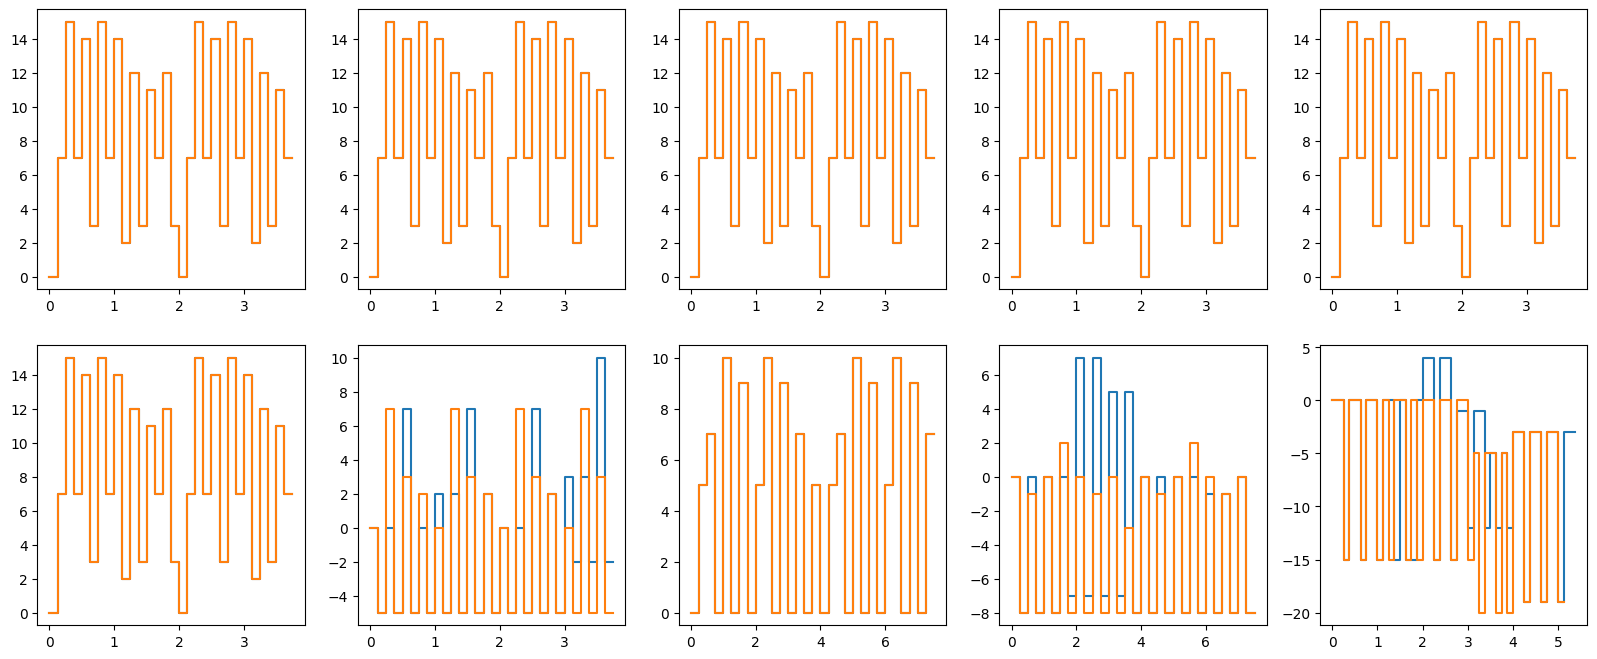

In [14]:
fig, ax = plt.subplots(n//5, 5, figsize=(20, 4*n//5))
for i in range(len(max_coords_value)):
    ax[i//5, i%5].plot(X[max_coords_value[i][0][0]].numpy()[:,0], X[max_coords_value[i][0][0]].numpy()[:,1])
    ax[i//5, i%5].plot(X[max_coords_value[i][0][1]].numpy()[:,0], X[max_coords_value[i][0][1]].numpy()[:,1])

In [15]:
# get coordinates (x,y) of lowest values in gram matrix
n = 10
min_coords_value = []
temp_matrix = torch.tril(gram_matrix, diagonal=-1)
for i in range(n):
    c = torch.argmin(temp_matrix).item()
    min_coords_value.append(((c//len(X), c%len(X)), torch.min(temp_matrix).item()))
    temp_matrix[c//len(X), c%len(X)] = np.inf
min_coords_value

[((6775, 5812), -5.631161689758301),
 ((5812, 5081), -5.018438816070557),
 ((5812, 4426), -3.803709030151367),
 ((5812, 2146), -3.6859207153320312),
 ((5812, 339), -2.779025077819824),
 ((5812, 1880), -2.4030425548553467),
 ((5812, 4718), -2.1080987453460693),
 ((6106, 1892), -1.3884503841400146),
 ((7239, 6775), -1.0734751224517822),
 ((6058, 4930), -0.9469228386878967)]

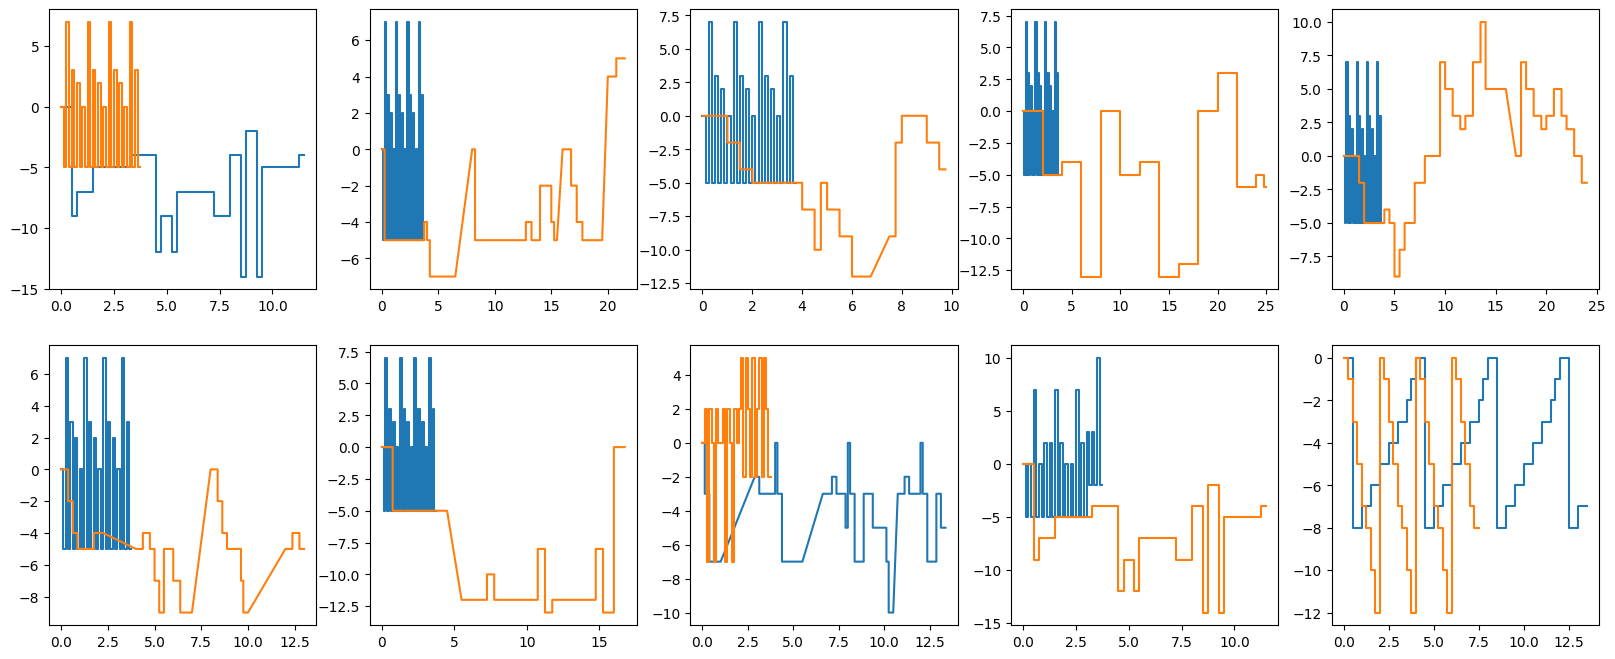

In [16]:
fig, ax = plt.subplots(n//5, 5, figsize=(20, 4*n//5))
for i in range(len(min_coords_value)):
    ax[i//5, i%5].plot(X[min_coords_value[i][0][0]].numpy()[:,0], X[min_coords_value[i][0][0]].numpy()[:,1])
    ax[i//5, i%5].plot(X[min_coords_value[i][0][1]].numpy()[:,0], X[min_coords_value[i][0][1]].numpy()[:,1])

In [17]:
sample_idx = min_coords_value[0][0][1]
print(sample_idx)
print(df_titles[sample_idx][1:])
midi_data = df_to_midi(df_titles[sample_idx][0])
fs = 44100
audio_data = midi_data.fluidsynth(fs=fs)
ipd.Audio(audio_data, rate=fs)

5812
('michiru-yamane', 'castlevania-sotn---wood-carving-partita', 'bridge_symbol_key.mid')


### Spectral clustering

(array([ 492., 1177.,  408.,   69.,  234.,  718.,  645.,  795.,  856.,
         663.,  497.,  713.]),
 array([ 0.        ,  0.91666667,  1.83333333,  2.75      ,  3.66666667,
         4.58333333,  5.5       ,  6.41666667,  7.33333333,  8.25      ,
         9.16666667, 10.08333333, 11.        ]),
 <BarContainer object of 12 artists>)

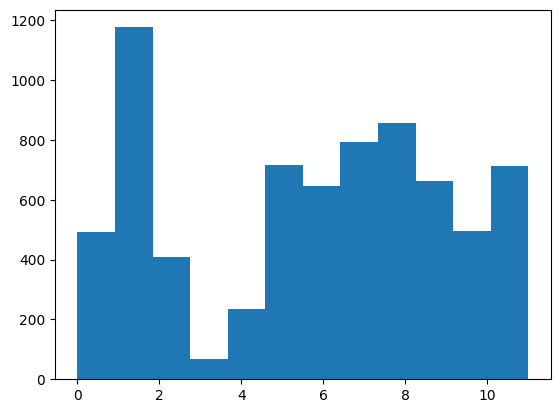

In [56]:
n_clusters = 12
labels = cluster.SpectralClustering(n_clusters=n_clusters, affinity='precomputed').fit(gram_matrix).labels_
plt.hist(labels, bins=n_clusters)

In [48]:
counts = np.unique(labels, return_counts=True)
counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32),
 array([ 792,  679, 1191,    4,   86,  882,  462,  718,  708,  542,  426,
         781]))

#### Remove duplicates

In [49]:
# get args of label with only 4 samples
args = [i for i in range(len(labels)) if labels[i] == 3]
args

[4154, 5177, 5281, 6599]

In [50]:
audio_datas = []
for arg in args:
    print(df_titles[arg][1:])
    midi_data = df_to_midi(df_titles[arg][0])
    fs = 44100
    audio_datas.append(midi_data.fluidsynth(fs=fs))

('tnorris', 'dorian-mode', 'verse_symbol_key.mid')
('psychictype', 'meter-analysis-algorithm', 'verse_symbol_key.mid')
('psycaudio', 'totally-not-a-sock-puppet', 'verse_symbol_key.mid')
('hooktheory', 'rampant-trolls-and-no-standards', 'verse_symbol_key.mid')


In [51]:
ipd.Audio(audio_datas[1], rate=fs)

In [54]:
# sort from largest to smallest then remove row and column in order
print(gram_matrix.shape)
for arg in np.sort(args)[::-1]:
    gram_matrix = torch.cat((gram_matrix[:arg], gram_matrix[arg+1:]))
    gram_matrix = torch.cat((gram_matrix[:,:arg], gram_matrix[:,arg+1:]), dim=1)
df_titles = [item for i, item in enumerate(df_titles) if i not in args]
gram_matrix.shape, len(df_titles)

(torch.Size([7267, 7267]), 7267)

In [57]:
df_titles_labels = [(df_titles[i][0], df_titles[i][1], df_titles[i][2], df_titles[i][3], labels[i]) for i in range(len(df_titles))]
with open(f'./data/dataframes/theorytab/melodies_beats_min_5_unique_max_range_24_spec_cluster_12.pkl', 'wb') as f:
    pickle.dump(df_titles_labels, f)
len(labels), len(df_titles), gram_matrix.shape[0]

(7267, 7267, 7267)

### Affinity propagation clustering

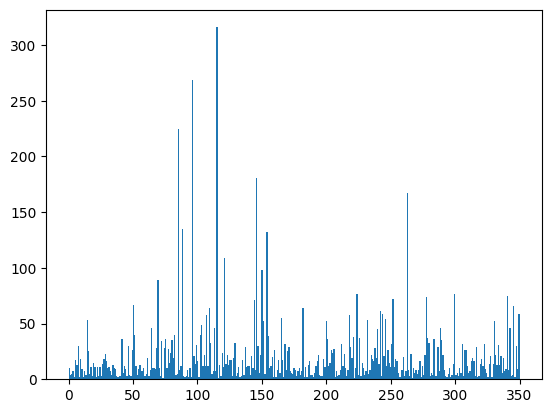

In [37]:
labels = cluster.AffinityPropagation(affinity='precomputed').fit(gram_matrix).labels_
barcontainer = plt.hist(labels, bins=len(np.unique(labels)))
counts = barcontainer[0]

In [38]:
# get args of top 10 counts
args = np.argsort(counts)[::-1][:10]
print(*zip(args, counts[args]))

(115, 316.0) (96, 269.0) (85, 225.0) (146, 181.0) (263, 167.0) (88, 135.0) (154, 132.0) (121, 109.0) (150, 98.0) (69, 89.0)


In [ ]:
# print(len(labels) == len(df_titles) == gram_matrix.shape[0])
# df_titles_labels = [(df_titles[i][0], df_titles[i][1], df_titles[i][2], df_titles[i][3], labels[i]) for i in range(len(df_titles))]
# with open(f'./data/dataframes/{folder}/melodies_beats_min_5_unique_max_range_24_affinity_cluster.pkl', 'wb') as f:
#     pickle.dump(df_titles_labels, f)
# len(df_titles_labels)

### Agglomerative clustering

In [39]:
# Convert gram matrix to distance matrix using Cauchy-Schwarz
# d_CS(x,y) = arccos k^2(x,y)/k(x,x)k(y,y).

# dist_matrix = torch.tril(gram_matrix, diagonal=-1)
# for i in range(len(X)):
#     dist_matrix[i:,i] /= torch.sqrt(gram_matrix[i,i]) * torch.diag(gram_matrix).sqrt()[i:]
# dist_matrix = torch.acos(dist_matrix)
# dist_matrix = torch.tril(dist_matrix, diagonal=-1) + torch.tril(dist_matrix, diagonal=-1).T
# dist_matrix

In [40]:
# Convert gram matrix to distance matrix using |u-v|^2 = k(x,x) + k(y,y) - 2k(x,y)

dist_matrix = -2*torch.tril(gram_matrix, diagonal=-1)
for i in range(gram_matrix.shape[0]):
    dist_matrix[i:,i] += gram_matrix[i,i] + torch.diag(gram_matrix)[i:]
dist_matrix = torch.sqrt(dist_matrix)
dist_matrix = torch.tril(dist_matrix, diagonal=-1) + torch.tril(dist_matrix, diagonal=-1).T
dist_matrix

tensor([[ 0.0000, 72.5786, 65.8663,  ..., 57.6016, 57.9588, 65.4663],
        [72.5786,  0.0000, 71.5906,  ..., 64.6447, 64.2513, 73.2348],
        [65.8663, 71.5906,  0.0000,  ..., 56.6133, 56.7124, 66.6175],
        ...,
        [57.6016, 64.6447, 56.6133,  ...,  0.0000, 47.3102, 58.2631],
        [57.9588, 64.2513, 56.7124,  ..., 47.3102,  0.0000, 58.6904],
        [65.4663, 73.2348, 66.6175,  ..., 58.2631, 58.6904,  0.0000]])

In [41]:
# normalise the distance matrix to [0,1]
dist_matrix -= dist_matrix.min()
dist_matrix /= dist_matrix.max()
dist_matrix

tensor([[0.0000, 0.2168, 0.1968,  ..., 0.1721, 0.1732, 0.1956],
        [0.2168, 0.0000, 0.2139,  ..., 0.1931, 0.1920, 0.2188],
        [0.1968, 0.2139, 0.0000,  ..., 0.1691, 0.1694, 0.1990],
        ...,
        [0.1721, 0.1931, 0.1691,  ..., 0.0000, 0.1414, 0.1741],
        [0.1732, 0.1920, 0.1694,  ..., 0.1414, 0.0000, 0.1754],
        [0.1956, 0.2188, 0.1990,  ..., 0.1741, 0.1754, 0.0000]])

<Axes: >

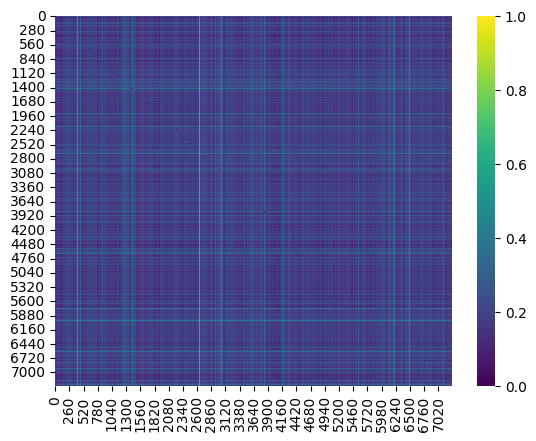

In [42]:
sns.heatmap(dist_matrix, cmap='viridis')

(array([7.258e+03, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

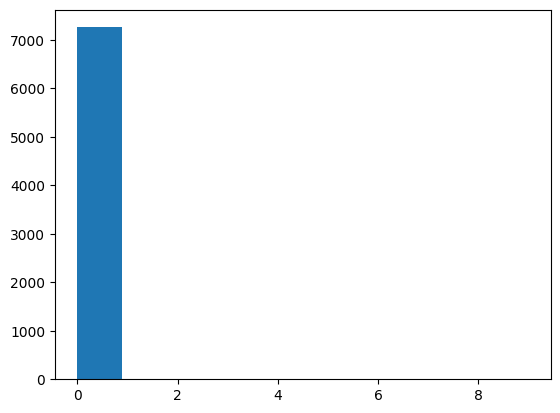

In [43]:
n_clusters = 10
labels = cluster.AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average').fit(dist_matrix).labels_
plt.hist(labels, bins=n_clusters)

### DBScan clustering

(array([5950., 1317.]),
 array([-1. , -0.5,  0. ]),
 <BarContainer object of 2 artists>)

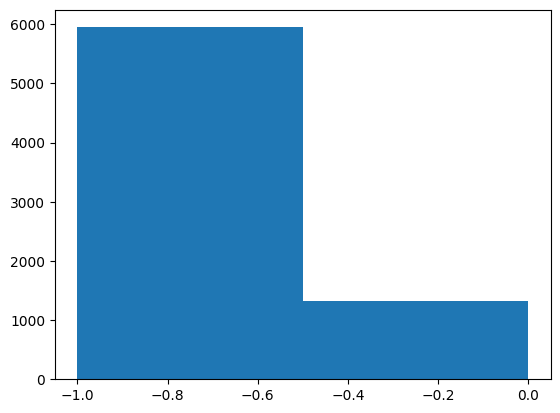

In [44]:
eps = 0.1
labels = cluster.DBSCAN(eps=eps, metric='precomputed').fit(dist_matrix).labels_
plt.hist(labels, bins=len(np.unique(labels)))